In [89]:
# DATA: https://www.eorc.jaxa.jp/ALOS/en/aw3d30/data/index.htm

# Script Making

In [150]:
import rasterio
import rasterio.features
import rasterio.transform
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import xy
import pandas as pd
from rasterio.plot import show
from rasterio.merge import merge 
import h5py
from matplotlib.colors import LogNorm

class ComboTile():
    
    def __init__(self, line):
        
        # TODO: integrate functionality for just typing with a print statement; add error handling for if tile does not exist
        #coords = input("Enter a coordinate center with convention 000.000 S/000.000 W: ")
        lat_coord, lon_coord = line.split('/')
        
        lat_deg, lat_direction = lat_coord.split()
        lon_deg, lon_direction = lon_coord.split()

        self.center = (lat_deg, lat_direction, lon_deg, lon_direction)
        
        degree_combinations = self.surrounding_tiles(float(lat_deg), float(lon_deg))
        print(degree_combinations)
        
        file_paths = [f"ALPSMLC30_{lat_direction}{combo[0]:03d}{lon_direction}{combo[1]:03d}_DSM.tif" for combo in degree_combinations]
            
        src_files_to_mosaic = [rasterio.open(file_path) for file_path in file_paths[:2]] ## remove indexing for full coverage
        
        
        self.mosaic, self.transform = merge(src_files_to_mosaic)
        
        self.elevations = self.mosaic[0]
        self.shape = self.mosaic[0].shape

    def surrounding_tiles(self, lat_center, lon_center, tile_size=1.0, grid_size=5):
        """Return an array of (lat, lon) pairs for a grid of surrounding tiles."""
        half = grid_size // 2
        offsets = np.arange(-half, half + 1) * tile_size

        # Each combination of offset lat/lon
        latitudes = lat_center + offsets
        longitudes = lon_center + offsets

        latlon_grid = np.stack(np.meshgrid(latitudes, longitudes, indexing='ij'), axis=-1)
        # shape: (grid_size, grid_size, 2), where [:,:,0] = lat, [:,:,1] = lon

        combos = [tuple(pair) for pair in latlon_grid.astype(int).reshape(-1, 2)]

        return combos
        
    # returns the minimum and maximum bounds for the latitude and longitude
    def tile_bounds(tile):
        rows, cols = tile.shape

        tl = xy(tile.transform, 0, 0)
        tr = xy(tile.transform, 0, cols-1)
        bl = xy(tile.transform, rows-1, 0)
        br = xy(tile.transform, rows-1, cols-1)
    
        lons = [tl[0], tr[0], bl[0], br[0]]
        lats = [tl[1], tr[1], bl[1], br[1]]
        return min(lons), max(lons), min(lats), max(lats) 
    
    def get_elevation(self, row, col):
        '''Returns the longitude, latitude, and elevation as a 3-element array for a specific tile object'''
        lon, lat = xy(self.transform, row, col)
        elev = self.elevations[row, col]
        return np.array([float(lat), float(lon), float(elev)])
    
    def map_table(self, want_grad: bool):
        '''Uses vectorization to create a list of the latitude, longitude, and elevation for each pixel in the tile'''
        rows, cols = np.indices(self.shape)
        lons, lats = xy(self.transform, rows, cols)

        if want_grad:
            grad_x, grad_y, slope, slope_deg = self.compute_gradient()
            return np.stack([
                lats.flatten(),
                lons.flatten(),
                self.elevations.flatten(),
                grad_x.flatten(),
                grad_y.flatten(),
                slope.flatten(),
                slope_deg.flatten()
            ], axis=1)

        return np.stack([lats.flatten(), lons.flatten(), self.elevations.flatten()], axis = 1)
        
    def plot_map(self, ax=None):

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        else:
            fig = ax.figure

        # Show the raster on this axes
        im = show(self.elevations, transform=self.transform, cmap='plasma', ax=ax)

        # Grab the image object created by show
        im = ax.images[0]  # THIS is the AxesImage

        # Now attach the colorbar to the figure
        cbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.7)
        cbar.set_label("Elevation (m)")

        ax.set_title("Elevation Map")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        
    def compute_gradient(self):
        dx_deg = self.transform.a
        dy_deg = -self.transform.e  # make positive
    
        # Approximate pixel size in meters
        # Use mean latitude of the tile for lon->meter scaling
        nrows, ncols = self.elevations.shape
        y0 = self.transform[3]
        mean_lat = y0 - (nrows / 2) * dy_deg
        lat_rad = np.radians(mean_lat)

        dx_m = 111_320 * np.cos(lat_rad) * dx_deg
        dy_m = 111_132 * dy_deg

        # Compute gradients in meters
        grad_y, grad_x = np.gradient(self.elevations, dy_m, dx_m)

        # Slope magnitude and slope angle in degrees
        slope = np.sqrt(grad_x**2 + grad_y**2)
        slope_deg = np.degrees(np.arctan(slope))

        return grad_x, grad_y, slope, slope_deg
        # should be 3D -> at a given elevation point, what is the tangent plane? 
        # get quantities necessary to define a tangent plane at a given point (center and normal vector)
        # NEED NORMAL VECTOR

    def plot_slope(self, want_log: bool, ax=None):
        """
        Visualize slope angles (in degrees) at each pixel.
        """
        _, _, _, slope_deg = self.compute_gradient()

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        else:
            fig = ax.figure
    
        # Use rasterio.plot.show to display slope with transform
        if want_log:
            im = show(
                slope_deg,
                transform=self.transform,
                cmap='inferno',
                norm=LogNorm(vmin=0.1, vmax=np.nanmax(slope_deg)),
                ax=ax,
                title="Slope Angle Map (degrees)"
            )
        else:
            im = show(
                slope_deg,
                transform=self.transform,
                cmap='inferno',
                vmin = 0, vmax = 15,
                ax=ax,
                title="Slope Angle Map (degrees)"
            )            

        cbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.7)
        cbar.set_label("Slope (degrees)")
        ax.set_title("Slope Map")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    def save_data(self, file_name, compute_gradients=True):
        """
        Build a TerrainData object from this tile and save to an HDF5 file.
        """
        rows, cols = np.indices(self.shape)
        lons, lats = xy(self.transform, rows, cols)

        if compute_gradients:
            grad_x, grad_y, slope, slope_deg = self.compute_gradient()
        else:
            grad_x = grad_y = slope = slope_deg = np.zeros_like(self.elevations)

        terrain = TerrainData(
            lats=lats,
            lons=lons,
            elev=self.elevations,
            grad_x=grad_x,
            grad_y=grad_y,
            slope=slope,
            slope_deg=slope_deg,
            shape=self.elevations.shape
        )

        terrain.save_to_h5(file_name=file_name)
        

class JTile(ComboTile):
    def __init__(self, file_name, root_dir="Gradient_Testing"):
        """
        Initialize JTile from a single DSM file.
        """
        print(file_name)
        lat_coord, lon_coord = line.split('/')
        
        lat_deg, lat_direction = lat_coord.split()
        lon_deg, lon_direction = lon_coord.split()

        self.center = (float(lat_deg), lat_direction, float(lon_deg), lon_direction)

        file_path = f"{root_dir}/ALPSMLC30_{lat_direction}{int(float(lat_deg)):03d}{lon_direction}{int(float(lon_deg)):03d}_DSM.tif"
        
        # Open the raster file
        with rasterio.open(file_path) as dsm:
            self.elevations = dsm.read(1)      # elevation array
            self.transform = dsm.transform     # affine transform
            self.nodata = dsm.nodata           # nodata value
            self.shape = self.elevations.shape # (rows, cols)

        # If needed, extract center coordinates from the raster bounds
        # e.g., for convenience:
        rows, cols = self.elevations.shape
        tl = xy(self.transform, 0, 0)
        br = xy(self.transform, rows-1, cols-1)
        center_lat = (tl[1] + br[1]) / 2
        center_lon = (tl[0] + br[0]) / 2
        self.center = (center_lat, center_lon)

   

In [151]:
import h5py 
import numpy as np

class TerrainData():
    '''Currently designed to be a wrapper for processing h5 files for terrain data.
        WORKFLOW:
        - Parse an ALOS World 3D tile and create the data structure using ComboTile
        - Use TerrainData to save and load h5 files using ComboTile data
        - TODO: Use TerrainData to sweep azimuth for highest elevation at each degree in 1 degree increments
    
    
    
    '''
    def __init__(self, lats, lons, elev, grad_x, grad_y, slope, slope_deg, shape=None):
        self.lats = lats
        self.lons = lons
        self.elev = elev
        self.grad_x = grad_x
        self.grad_y = grad_y
        self.slope = slope
        self.slope_deg = slope_deg
        
        if shape is None:
            self.shape = self.lats.shape
        else:
            self.shape = shape

    def save_to_h5(self, file_name, dtype=np.float32, compression="gzip", compression_opts=6):
        """
        Save the TerrainData object to an HDF5 file. 
        """
        rows, cols = self.shape

        # Flatten arrays for storage
        lats_flat      = self.lats.flatten().astype(dtype)
        lons_flat      = self.lons.flatten().astype(dtype)
        elev_flat      = self.elev.flatten().astype(dtype)
        grad_x_flat    = self.grad_x.flatten().astype(dtype)
        grad_y_flat    = self.grad_y.flatten().astype(dtype)
        slope_flat     = self.slope.flatten().astype(dtype)
        slope_deg_flat = self.slope_deg.flatten().astype(dtype)

        # Stack as (rows*cols, 7)
        data_tile = np.stack([
            lats_flat, lons_flat, elev_flat,
            grad_x_flat, grad_y_flat, slope_flat, slope_deg_flat
        ], axis=1)

        # Save to HDF5
        with h5py.File(file_name, "w") as f:
            dset = f.create_dataset(
                "terrain_data",
                data=data_tile,
                dtype=dtype,
                compression=compression,
                compression_opts=compression_opts,
                chunks=True
            )
            dset.attrs["headers"] = np.string_([
                "latitude", "longitude", "elevation",
                "gradient_x", "gradient_y", "slope", "slope_deg"
            ])

            # Save shape for reconstruction
            f.attrs["rows"] = rows
            f.attrs["cols"] = cols
            
    @staticmethod
    def load_terrain_data(file_name):
        """
        Load TerrainData from an HDF5 file.
        Returns a TerrainData object with 2D NumPy arrays.
        """
        with h5py.File(file_name, "r") as f:
            if "terrain_data" not in f:
                raise KeyError("Dataset 'terrain_data' not found in file.")
        
            # Load the flattened data
            data = f["terrain_data"][:]  # shape: (rows*cols, 7)
        
            # Read the original 2D shape from attributes
            rows, cols = f.attrs["rows"], f.attrs["cols"]
            shape = (rows, cols)

        # Reconstruct 2D arrays from flattened data
        return TerrainData(
            lats      = data[:, 0].reshape(shape),
            lons      = data[:, 1].reshape(shape),
            elev      = data[:, 2].reshape(shape),
            grad_x    = data[:, 3].reshape(shape),
            grad_y    = data[:, 4].reshape(shape),
            slope     = data[:, 5].reshape(shape),
            slope_deg = data[:, 6].reshape(shape),
            shape     = shape  # pass explicit shape
        )

    # ---- Getter Methods ----
    
    def get_latitudes(self):
        return self.lats

    def get_longitudes(self):
        return self.lons

    def get_elevation(self):
        return self.elev

    def get_gradient_x(self):
        return self.grad_x

    def get_gradient_y(self):
        return self.grad_y

    def get_slope(self):
        return self.slope

    def get_slope_deg(self):
        return self.slope_deg
    


# Testing Gradients

In [152]:
lines = ["006.000 N/010.000 E", "017.000 N/097.000 W", "030.000 N/107.000 E", "037.000 N/108.000 W", "042.000 N/074.000 W",
        "052.000 N/072.000 E", "018.000 S/045.000 E", "018.000 S/045.000 W", "019.000 S/142.000 E", "072.000 S/067.000 E"
                ]
root = "Gradient_Testing/"

tile_list = []

for line in lines:
    tile_list.append(JTile(f"{line}"))

006.000 N/010.000 E
017.000 N/097.000 W
030.000 N/107.000 E
037.000 N/108.000 W
042.000 N/074.000 W
052.000 N/072.000 E
018.000 S/045.000 E
018.000 S/045.000 W
019.000 S/142.000 E
072.000 S/067.000 E


In [153]:
tile_list[0].elevations.min()

176

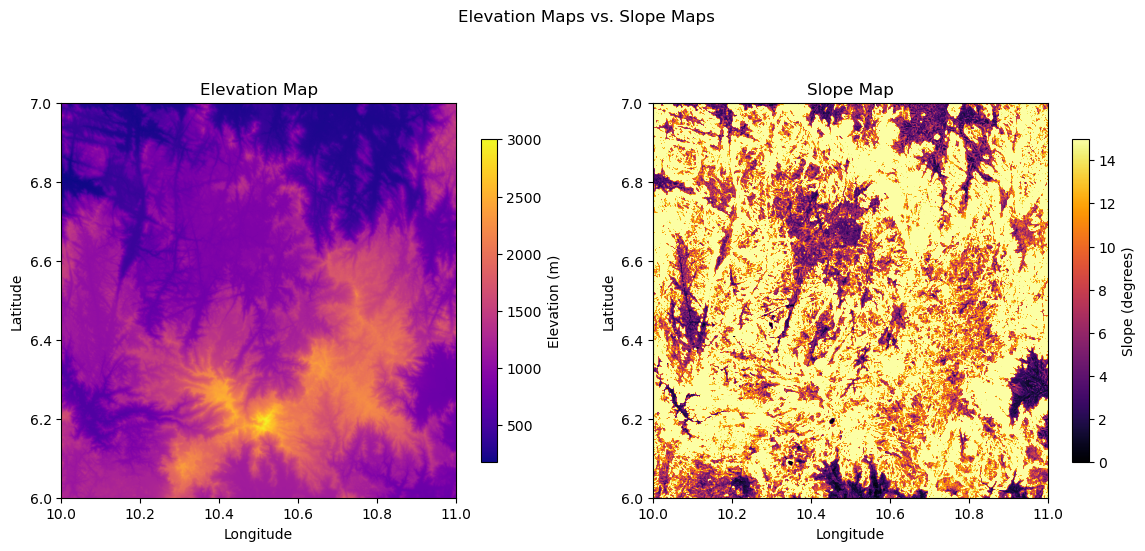

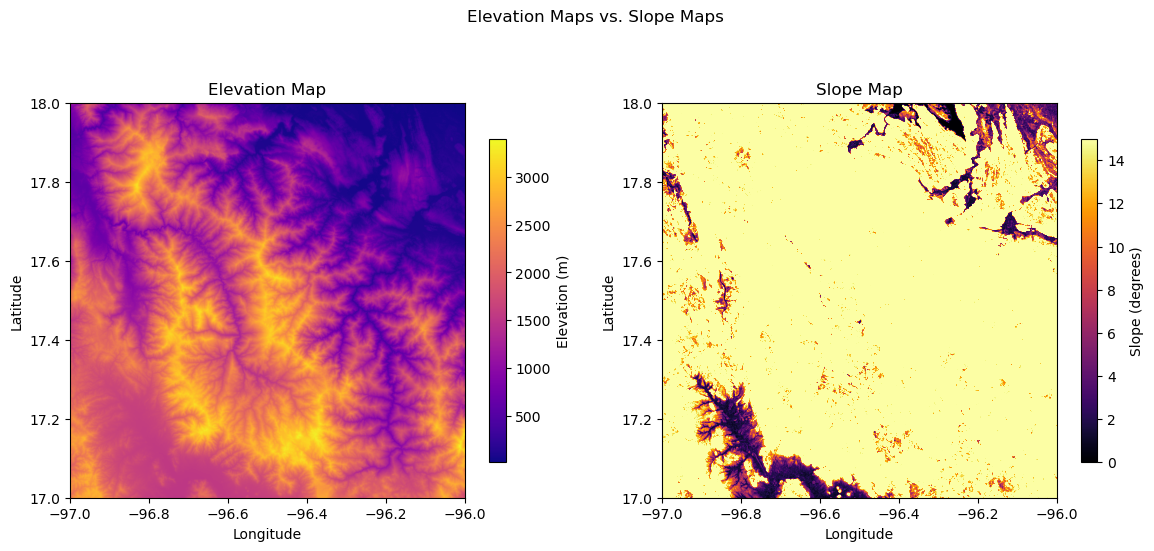

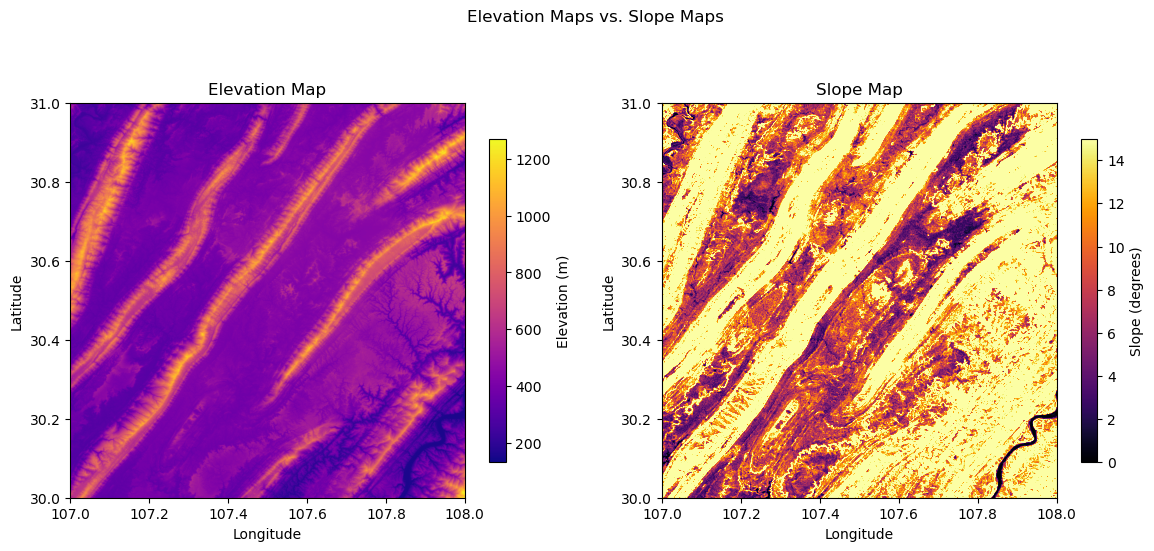

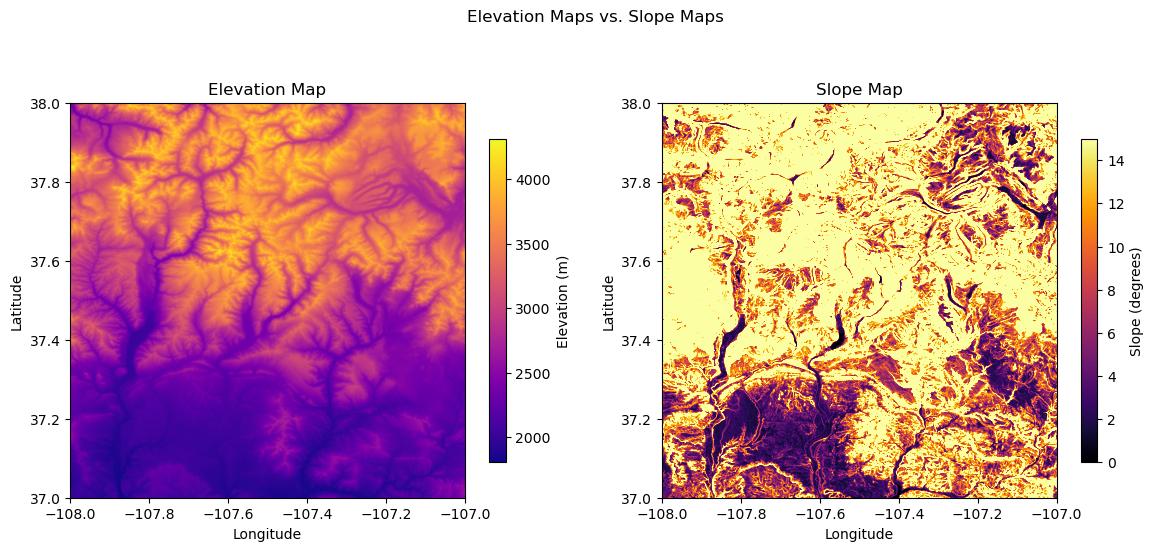

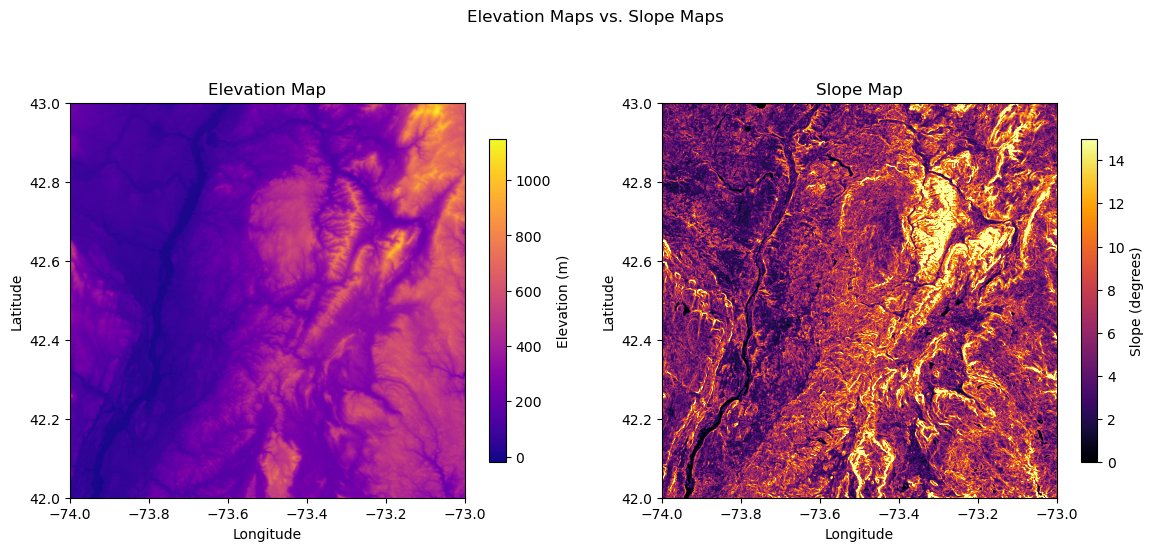

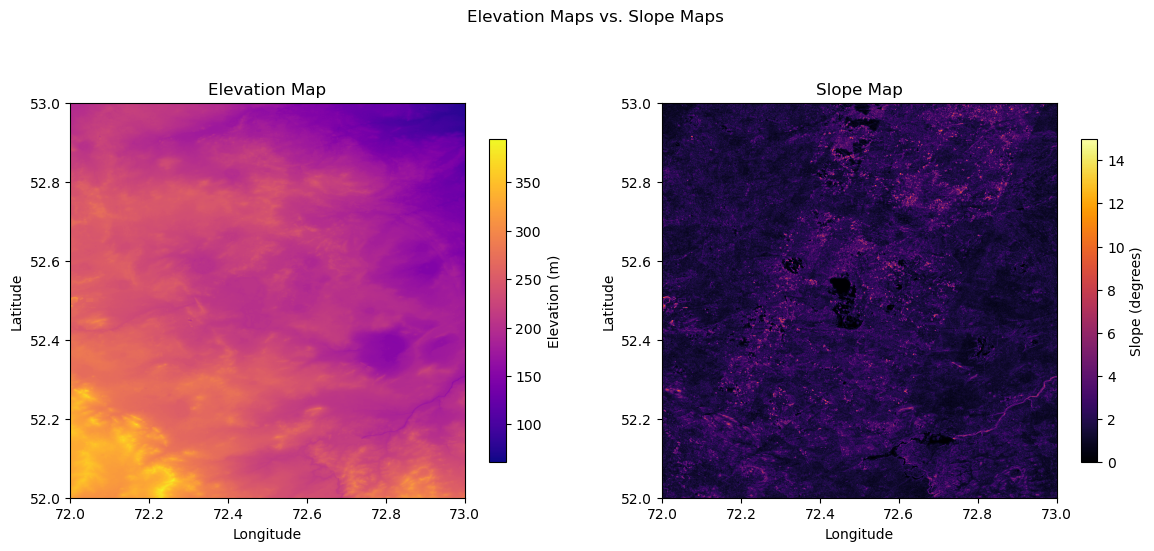

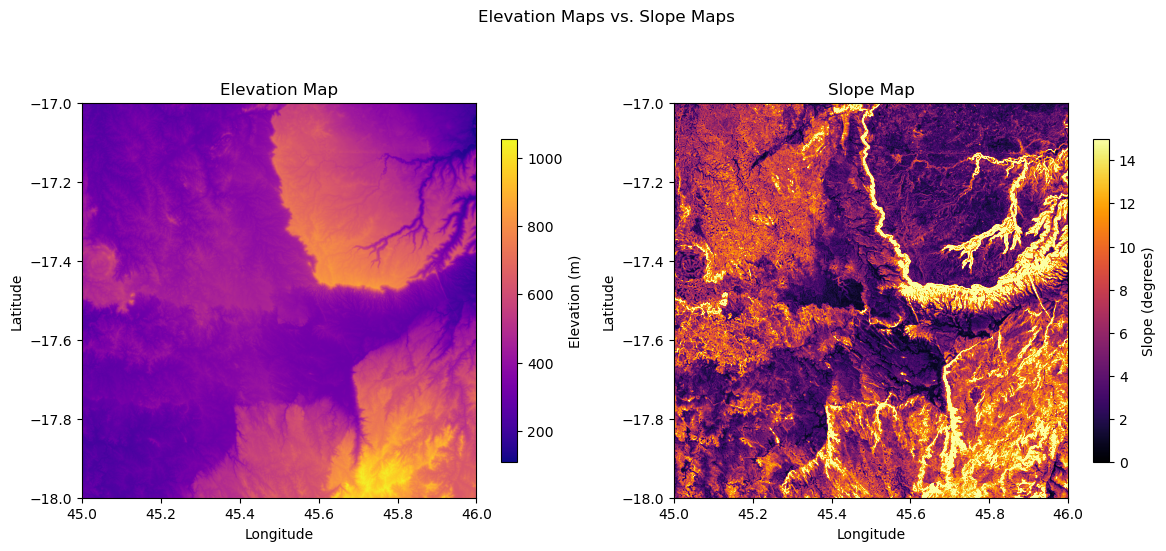

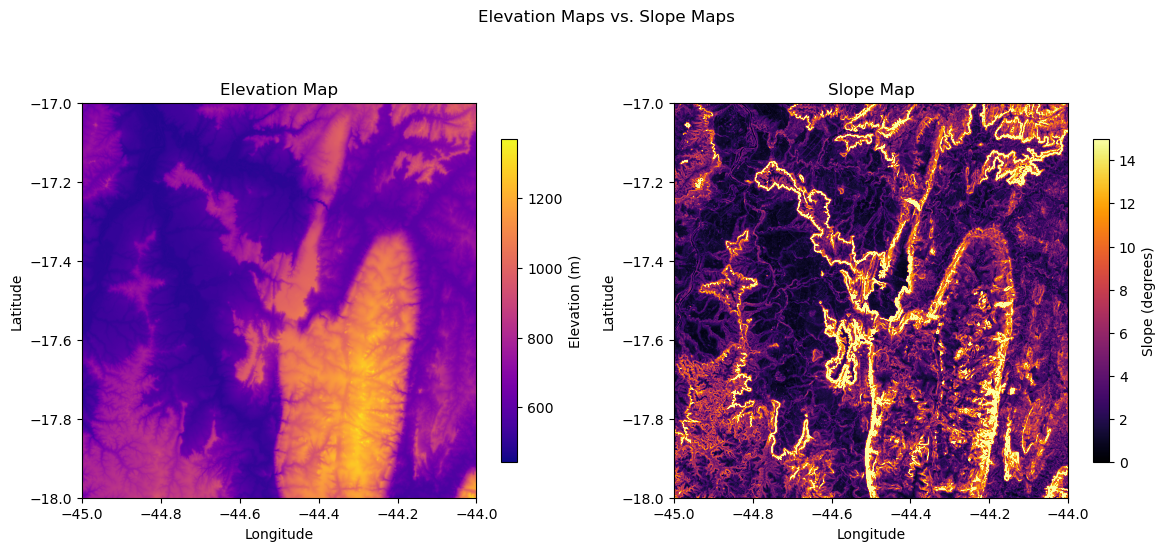

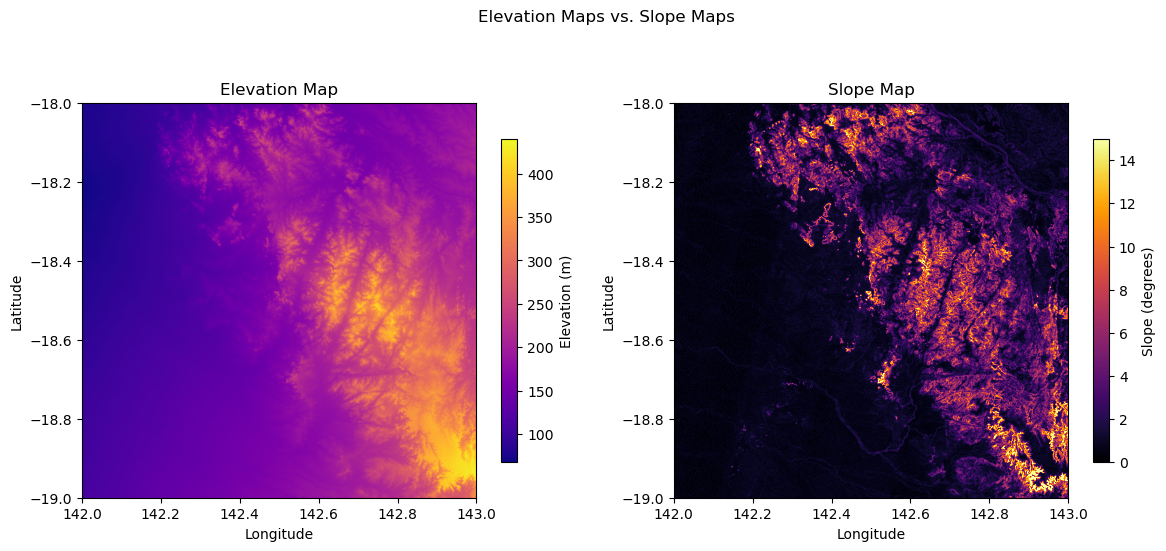

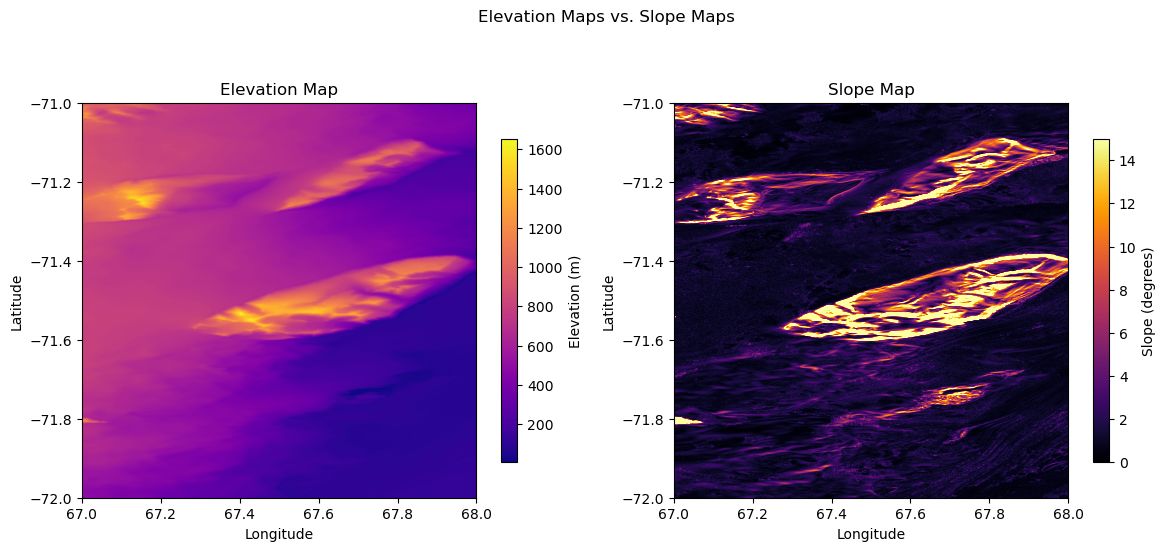

In [155]:
for tile in tile_list:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Elevation Maps vs. Slope Maps')
    tile.plot_map(ax=ax1)
    tile.plot_slope(want_log=False, ax=ax2)

In [13]:
combo_tile.elevations.shape



#import h5py as h5

In [2]: h5.File("test.h5","r")
Out[2]: <HDF5 file "test.h5" (mode r)>

In [3]: hf = h5.File("test.h5","r")

In [4]: hf
Out[4]: <HDF5 file "test.h5" (mode r)>

In [5]: hf.keys()
Out[5]: <KeysViewHDF5 ['terrain_data']>

In [6]: hf['terrain_data']
Out[6]: <HDF5 dataset "terrain_data": shape (38880000, 7), type "<f8">

In [7]: x =  hf['terrain_data']

In [8]: x
Out[8]: <HDF5 dataset "terrain_data": shape (38880000, 7), type "<f8">

In [9]: import numpy as np

In [10]: y = np.array(x)

In [11]: y.shape
Out[11]: (38880000, 7)

In [12]: y[1]
Out[12]: 
array([ 3.59998611e+01, -1.02999583e+02,  1.34400000e+03,  0.00000000e+00,
        3.23939099e-02,  3.23939099e-02,  1.85538551e+00])

In [13]: 


SyntaxError: invalid syntax (2781471997.py, line 8)

In [132]:
tile_list[0].save_data("006N_010E.h5")

In [136]:
hf = h5.File("006N_010E.h5", "r")
hf["terrain_data"]

<HDF5 dataset "terrain_data": shape (12960000, 7), type "<f4">

In [137]:
tile_list[0].shape

(3600, 3600)

In [130]:
import h5py as h5

hf = h5.File("test.h5","r")
hf["terrain_data"]

<HDF5 dataset "terrain_data": shape (38880000, 7), type "<f4">

In [14]:
JTile("ALPSMLC30_N037W103_DSM.tif").map_table().shape

(12960000, 3)

In [118]:
# 9/30
# need a 5x5 map based off of 3 degree calculation from 10 km out theta = arccos(r/(r+dx))
# fix gradient calculations
# save array with gradients/slope angles as binary file with metadata (point requested, total size, etc. )
# adjustment for elevations with respect to a flat plane (currently elevations are computed with respect to a curved surface)
# can assume a perfect sphere for adjustment -> essentially a height projection

# 10/7
# create your own elevation map with a fixed (known) slope angle and compute the gradient to make sure it matches
# save as HDF5 file with h5py (not a txt file)

# 10/14

# ADD FUNCTIONALITY TO READ DATA
# UPLOAD TO GITHUB REPO AND SHARE
# Test different tiles (approx 10 or so) and check visually both the terrain and gradient/slope angles to make sure it makes sense everywhere
# make a little presentation to show functionality
# when saving hdf5 file, add functionality for file name customization
# start working on sweeping azimuth for highest elevation (every 1 degree) -> eventually save as a second array to the file

# 10/21
# Create your own array of elevation values with an easy gradient
# do completely flat, then gradally increasing so gradient is constant, then different maps like x^2, and more stuff that you know the gradient for
# Verification for small scales that we're seeing but not large scale structure
# Create a toy mountain (cone)
# raumonsalve@gmail.com

In [85]:
# investigate how satellite data is flattened 
# scalar projection of curve onto observation point
# find highest points at each azimuth
# find line tangent to observation point relative to earth curvature and only keep data above the tangent line
# compute elevation angle gamma for each height point -> report highest gamma for each azimuth (azimuth is a direction, so highest elevation in a particular direction of sight)
# return a gamma max at each azimuth as a 2d array
# defines how sky is blocked
# make a flat plane; selection process will auto select the "radius"
# report the azimuth of the highest points, not discrete bins of azimuth angles
# after getting azimuth angles, bin by azimuth angle and select (bins are 0 deg to 360 deg, unique to data)

# DATA PRODUCT
# Compute gradient for each 30m x 30m pixel -> compute slope angles for each point

In [ ]:
rows, cols = np.indices(self.shape)
lons, lats = xy(self.transform, rows, cols)
return np.stack([lats.flatten(), lons.flatten(),self.elevations.flatten()], axis = 1)

Make sure to compare to google earth resolution/data -> just for comparison 
    


make a secondary class that works with JTiles and ComboTiles to create an elevation map cutout for a pre-defined radius
        
clip cirlces as a polygon and use geopandas???

In [154]:
# finding tiles from the center -> truncate N/S coordinate and E/W coordinate
# need tiles with trunc(N/S),  trunc(N/S) + 1, trunc(E/W), trunc(E/W) + 1